In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Concatenate
from tensorflow.keras.models import Model
import keras_ocr
from tensorflow.keras.layers import Reshape, Dense
from sklearn.model_selection import train_test_split

In [34]:
# Загрузка путей к изображениям и меток
def load_data(dataset_path):
    image_paths = []
    labels = []
    
    for digit_dir in os.listdir(dataset_path):
        digit_path = os.path.join(dataset_path, digit_dir)
        if not os.path.isdir(digit_path):
            continue
            
        for img_file in os.listdir(digit_path):
            if img_file.endswith('.png'):
                image_paths.append(os.path.join(digit_path, img_file))
                labels.append(int(digit_dir))
    
    return image_paths, labels

images, labels = load_data('/home/lastinm/PROJECTS/CV/CreditCards/datasets/digits')
# Разделение на train/validation
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [35]:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [31, 200])  # Стандартный размер для keras-ocr
    return image, label

def create_dataset(image_paths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images, train_labels)
val_dataset = create_dataset(val_images, val_labels)

In [ ]:
def build_custom_model():
    # Входные слои (как ожидает оригинальная модель)
    image_input = Input(shape=(31, 200, 1), name='image')
    width_input = Input(shape=(), name='width', dtype=tf.float32)
    height_input = Input(shape=(), name='height', dtype=tf.float32)
    dummy_input = Input(shape=(), name='dummy', dtype=tf.float32)
    
    # Первые слои (до проблемного Lambda)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(image_input)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    
    # Заменяем проблемный Lambda-слой
    x = Dense(64, activation='relu')(x)  # Замена lambda_45
    
    # Продолжаем оригинальную архитектуру
    x = Dense(128, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    
    return Model(
        inputs=[image_input, width_input, height_input, dummy_input],
        outputs=outputs
    )

In [33]:
# Создаем кастомную модель
custom_model = build_custom_model()

# Загружаем веса до проблемного слоя (если нужно)
try:
    original_model = keras_ocr.pipeline.Pipeline().recognizer.training_model
    for i, layer in enumerate(custom_model.layers[:5]):  # Копируем первые 5 слоев
        if hasattr(layer, 'weights'):
            layer.set_weights(original_model.layers[i].get_weights())
except:
    print("Инициализируем веса случайным образом")

# Компиляция
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение
history = custom_model.fit(
    train_dataset,  # Ваш DataGenerator
    epochs=30,
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5')
    ]
)

Looking for /home/lastinm/.keras-ocr/craft_mlt_25k.h5
Looking for /home/lastinm/.keras-ocr/crnn_kurapan.h5
Инициализируем веса случайным образом
Epoch 1/30
23/23 [==============================] - 1s 43ms/step - loss: 2.2931 - accuracy: 0.1356 - val_loss: 2.2804 - val_accuracy: 0.1412
Epoch 2/30
 3/23 [==>...........................] - ETA: 0s - loss: 2.2246 - accuracy: 0.2188

/home/lastinm/PROJECTS/credit_cards_detection/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 1s 44ms/step - loss: 2.2311 - accuracy: 0.1864 - val_loss: 2.2174 - val_accuracy: 0.2768
Epoch 3/30
23/23 [==============================] - 1s 43ms/step - loss: 2.1228 - accuracy: 0.2768 - val_loss: 2.1152 - val_accuracy: 0.3051
Epoch 4/30
23/23 [==============================] - 1s 43ms/step - loss: 1.9428 - accuracy: 0.3362 - val_loss: 1.9202 - val_accuracy: 0.3446
Epoch 5/30
23/23 [==============================] - 1s 43ms/step - loss: 1.6689 - accuracy: 0.4633 - val_loss: 1.6738 - val_accuracy: 0.4915
Epoch 6/30
23/23 [==============================] - 1s 44ms/step - loss: 1.3752 - accuracy: 0.5918 - val_loss: 1.4351 - val_accuracy: 0.5650
Epoch 7/30
23/23 [==============================] - 1s 43ms/step - loss: 1.1024 - accuracy: 0.6864 - val_loss: 1.2470 - val_accuracy: 0.6045
Epoch 8/30
23/23 [==============================] - 1s 43ms/step - loss: 0.8718 - accuracy: 0.7825 - val_loss: 1.0965 - val_accuracy: 0.6384
Epoch 9/30
23/23 [======

In [39]:
custom_model.save('custom_digits_recognizer.h5')

/home/lastinm/PROJECTS/credit_cards_detection/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
def create_compatible_recognizer(custom_model):
    # Создаем оригинальную модель recognizer
    pipeline = keras_ocr.pipeline.Pipeline()
    recognizer = pipeline.recognizer
    
    # Переносим обученные веса
    for custom_layer, original_layer in zip(custom_model.layers, recognizer.training_model.layers):
        if hasattr(original_layer, 'weights') and hasattr(custom_layer, 'weights'):
            try:
                original_layer.set_weights(custom_layer.get_weights())
            except:
                print(f"Не удалось перенести веса для слоя {original_layer.name}")
    
    return recognizer

# Создаем совместимый recognizer
trained_recognizer = create_compatible_recognizer(custom_model)
trained_recognizer.training_model.save('trained_ocr.h5')

# Использование в пайплайне
pipeline = keras_ocr.pipeline.Pipeline(recognizer=trained_recognizer)

Looking for /home/lastinm/.keras-ocr/craft_mlt_25k.h5
Looking for /home/lastinm/.keras-ocr/crnn_kurapan.h5
Не удалось перенести веса для слоя permute_13
Не удалось перенести веса для слоя conv_1
Не удалось перенести веса для слоя conv_2
Не удалось перенести веса для слоя conv_3
Не удалось перенести веса для слоя bn_3
Не удалось перенести веса для слоя conv_4
Не удалось перенести веса для слоя conv_5
Не удалось перенести веса для слоя bn_5
Looking for /home/lastinm/.keras-ocr/craft_mlt_25k.h5


In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

1/1 [==============================] - 1s 990ms/step


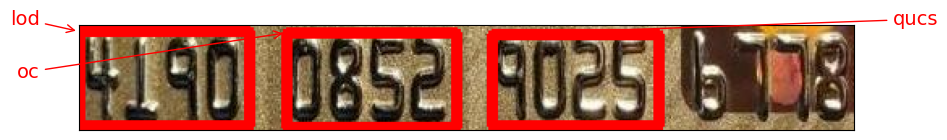

In [42]:
# Тестирование
test_img = keras_ocr.tools.read('/home/lastinm/PROJECTS/credit_cards_detection/artefacts/2_0.93_AgACAgIAAxkBAAICb2gDc1odBGUeYrwLDCqbVKbzKukKAALx7jEb9jsYSCYoYdOUlI6-AQADAgADeAADNgQ.jpeg')
predictions = pipeline.recognize([test_img])

# Визуализация
fig, ax = plt.subplots(figsize=(10, 10))
keras_ocr.tools.drawAnnotations(image=test_img, predictions=predictions[0], ax=ax)
plt.show()